In [17]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


## Data Preparation
1. Get __Olist data__ from Olist().get_data()
2. Get __Seller data__ from Seller().get_training_data() which has the new column </br>'cost_of_reviews': cost(BRL). This sums the costs per seller as below:</br>
{'1 star': 100</br>
'2 stars': 50</br>
'3 stars': 40</br>
'4 stars': 0</br>
'5 stars': 0}

In [18]:
from olist.data import Olist
from olist.seller import Seller

data = Olist().get_data().copy()
print("column names from Olist: \n",data.keys())
print("==============================================")
sellers = Seller().get_training_data().copy()
print("column names from Seller: \n",sellers.keys())


column names from Olist: 
 dict_keys(['sellers', 'product_category_name_translation', 'orders', 'order_items', 'customers', 'geolocation', 'order_payments', 'order_reviews', 'products'])
column names from Seller: 
 Index(['seller_id', 'seller_city', 'seller_state', 'delay_to_carrier',
       'wait_time', 'date_first_sale', 'date_last_sale', 'months_on_olist',
       'share_of_one_stars', 'share_of_five_stars', 'review_score',
       'cost_of_reviews', 'n_orders', 'quantity', 'quantity_per_order',
       'sales', 'revenues', 'profits'],
      dtype='object')


### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  

1. Merge sellers and order_items to include freight_values
2. Calculate Sales fees

In [19]:
sellers.head(5)


,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,341.870,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2290.307,2050.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00,15.800,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99,7.999,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99,16.799,-83.201


In [20]:
freight_sellers = (
    data["order_items"][["seller_id", "freight_value"]]
    .groupby("seller_id")
    .sum()
    .rename(columns={"freight_value": "sales_freight"})
)
sellers = sellers.merge(freight_sellers, on="seller_id")


In [21]:
#### Calculate Sales fess
sellers["sales_fees"] = 0.01 * (sellers["sales"] - sellers["sales_freight"])
sellers


,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,sales_freight,sales_fees
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000000,218.70,341.870,201.870,27.90,1.9080
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025000,11703.07,2290.307,2050.307,1438.73,102.6434
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000000,158.00,15.800,15.800,16.21,1.4179
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000000,79.99,7.999,7.999,15.66,0.6433
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000000,167.99,16.799,-83.201,31.93,1.3606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,98dddbc4601dd4443ca174359b237166,sarandi,PR,0.000000,8.230822,2018-07-14 03:10:19,2018-07-23 15:34:03,0.0,0.000000,1.000000,5.00,0,2,2,1.000000,158.00,15.800,15.800,53.67,1.0433
2963,f8201cab383e484733266d1906e2fdfa,palhoca,SC,0.000000,13.045797,2017-06-17 15:30:11,2018-08-11 19:55:17,14.0,0.100000,0.500000,4.10,140,10,10,1.000000,889.00,1208.900,1068.900,255.83,6.3317
2964,74871d19219c7d518d0090283e03c137,sao paulo,SP,0.000000,3.606625,2018-04-05 17:09:46,2018-08-21 19:25:15,5.0,0.000000,1.000000,5.00,0,6,7,1.166667,550.04,455.004,455.004,87.87,4.6217
2965,e603cf3fec55f8697c9059638d6c8eb5,pelotas,RS,0.000000,6.657634,2017-02-09 02:43:17,2017-06-16 17:30:16,4.0,0.000000,0.500000,4.25,50,8,11,1.375000,297.00,349.700,299.700,185.47,1.1153


- Compute **Subscription fees:** Olist charges **80 BRL by month** per seller####

In [22]:
condition = sellers["months_on_olist"] > 0
sellers.loc[condition, "subscription_fees"] = 80 * sellers["months_on_olist"]
sellers.loc[~condition, "subscription_fees"] = 80
sellers


,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,sales_freight,sales_fees,subscription_fees
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,...,140,3,3,1.000000,218.70,341.870,201.870,27.90,1.9080,320.0
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,...,240,40,41,1.025000,11703.07,2290.307,2050.307,1438.73,102.6434,1120.0
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,...,0,1,1,1.000000,158.00,15.800,15.800,16.21,1.4179,80.0
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,...,0,1,1,1.000000,79.99,7.999,7.999,15.66,0.6433,80.0
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,...,100,1,1,1.000000,167.99,16.799,-83.201,31.93,1.3606,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,98dddbc4601dd4443ca174359b237166,sarandi,PR,0.000000,8.230822,2018-07-14 03:10:19,2018-07-23 15:34:03,0.0,0.000000,1.000000,...,0,2,2,1.000000,158.00,15.800,15.800,53.67,1.0433,80.0
2963,f8201cab383e484733266d1906e2fdfa,palhoca,SC,0.000000,13.045797,2017-06-17 15:30:11,2018-08-11 19:55:17,14.0,0.100000,0.500000,...,140,10,10,1.000000,889.00,1208.900,1068.900,255.83,6.3317,1120.0
2964,74871d19219c7d518d0090283e03c137,sao paulo,SP,0.000000,3.606625,2018-04-05 17:09:46,2018-08-21 19:25:15,5.0,0.000000,1.000000,...,0,6,7,1.166667,550.04,455.004,455.004,87.87,4.6217,400.0
2965,e603cf3fec55f8697c9059638d6c8eb5,pelotas,RS,0.000000,6.657634,2017-02-09 02:43:17,2017-06-16 17:30:16,4.0,0.000000,0.500000,...,50,8,11,1.375000,297.00,349.700,299.700,185.47,1.1153,320.0


- Compute __`revenues`__: sum of subscription and sales fees revenues

In [23]:
sellers["revenues"] = sellers["sales_fees"] + sellers["subscription_fees"]
sellers


,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,sales_freight,sales_fees,subscription_fees
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,...,140,3,3,1.000000,218.70,321.9080,201.870,27.90,1.9080,320.0
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,...,240,40,41,1.025000,11703.07,1222.6434,2050.307,1438.73,102.6434,1120.0
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,...,0,1,1,1.000000,158.00,81.4179,15.800,16.21,1.4179,80.0
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,...,0,1,1,1.000000,79.99,80.6433,7.999,15.66,0.6433,80.0
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,...,100,1,1,1.000000,167.99,81.3606,-83.201,31.93,1.3606,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,98dddbc4601dd4443ca174359b237166,sarandi,PR,0.000000,8.230822,2018-07-14 03:10:19,2018-07-23 15:34:03,0.0,0.000000,1.000000,...,0,2,2,1.000000,158.00,81.0433,15.800,53.67,1.0433,80.0
2963,f8201cab383e484733266d1906e2fdfa,palhoca,SC,0.000000,13.045797,2017-06-17 15:30:11,2018-08-11 19:55:17,14.0,0.100000,0.500000,...,140,10,10,1.000000,889.00,1126.3317,1068.900,255.83,6.3317,1120.0
2964,74871d19219c7d518d0090283e03c137,sao paulo,SP,0.000000,3.606625,2018-04-05 17:09:46,2018-08-21 19:25:15,5.0,0.000000,1.000000,...,0,6,7,1.166667,550.04,404.6217,455.004,87.87,4.6217,400.0
2965,e603cf3fec55f8697c9059638d6c8eb5,pelotas,RS,0.000000,6.657634,2017-02-09 02:43:17,2017-06-16 17:30:16,4.0,0.000000,0.500000,...,50,8,11,1.375000,297.00,321.1153,299.700,185.47,1.1153,320.0


### Profits
- Compute individual seller's __`profits`__: `revenues` - `cost_of_reviews`

In [24]:
sellers['profits'] = sellers['revenues'] - sellers['cost_of_reviews']
sellers


,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,sales_freight,sales_fees,subscription_fees
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,...,140,3,3,1.000000,218.70,321.9080,181.9080,27.90,1.9080,320.0
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,...,240,40,41,1.025000,11703.07,1222.6434,982.6434,1438.73,102.6434,1120.0
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,...,0,1,1,1.000000,158.00,81.4179,81.4179,16.21,1.4179,80.0
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,...,0,1,1,1.000000,79.99,80.6433,80.6433,15.66,0.6433,80.0
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,...,100,1,1,1.000000,167.99,81.3606,-18.6394,31.93,1.3606,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,98dddbc4601dd4443ca174359b237166,sarandi,PR,0.000000,8.230822,2018-07-14 03:10:19,2018-07-23 15:34:03,0.0,0.000000,1.000000,...,0,2,2,1.000000,158.00,81.0433,81.0433,53.67,1.0433,80.0
2963,f8201cab383e484733266d1906e2fdfa,palhoca,SC,0.000000,13.045797,2017-06-17 15:30:11,2018-08-11 19:55:17,14.0,0.100000,0.500000,...,140,10,10,1.000000,889.00,1126.3317,986.3317,255.83,6.3317,1120.0
2964,74871d19219c7d518d0090283e03c137,sao paulo,SP,0.000000,3.606625,2018-04-05 17:09:46,2018-08-21 19:25:15,5.0,0.000000,1.000000,...,0,6,7,1.166667,550.04,404.6217,404.6217,87.87,4.6217,400.0
2965,e603cf3fec55f8697c9059638d6c8eb5,pelotas,RS,0.000000,6.657634,2017-02-09 02:43:17,2017-06-16 17:30:16,4.0,0.000000,0.500000,...,50,8,11,1.375000,297.00,321.1153,271.1153,185.47,1.1153,320.0


 - Sort sellers by increasing profits

In [25]:
sellers = sellers.sort_values(by='profits', ascending=True)
sellers


,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,sales_freight,sales_fees,subscription_fees
2358,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,0.143809,0.482510,...,39400,1806,1987,1.100221,200472.92,3254.0588,-36145.9412,35067.04,1654.0588,1600.0
769,6560211a19b47992c3666cc44a7e94c0,sao paulo,SP,0.0,9.539486,2017-02-17 07:45:11,2018-08-29 09:25:12,18.0,0.124729,0.514100,...,35290,1854,2033,1.096548,123304.83,2393.4389,-32896.5611,27960.94,953.4389,1440.0
1357,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,0.116092,0.584483,...,29530,1706,1775,1.040445,104288.42,2306.1943,-27223.8057,25668.99,786.1943,1520.0
1132,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,SP,0.0,22.392546,2017-01-26 22:55:10,2018-08-08 03:10:34,18.0,0.199593,0.351324,...,28250,982,1364,1.389002,187923.89,2803.1134,-25446.8866,51612.55,1363.1134,1440.0
453,1f50f920176fa81dab994f9023523100,sao jose do rio preto,SP,0.0,15.571831,2017-04-03 22:15:14,2018-08-28 03:45:18,17.0,0.112536,0.600427,...,21980,1404,1931,1.375356,106939.21,2077.7344,-19902.2656,35165.77,717.7344,1360.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1789,afa6714acee029b2dfdf357e5579cc03,descalvado,SP,0.0,12.618580,2016-10-08 18:54:23,2018-08-20 15:11:33,22.0,0.125000,0.687500,...,240,16,17,1.062500,3220.76,1788.3794,1548.3794,382.82,28.3794,1760.0
2826,612a743d294c27884fb7b80d2b19ba35,curitiba,PR,0.0,8.214742,2017-01-25 13:02:09,2018-08-16 14:46:20,19.0,0.000000,0.500000,...,0,2,3,1.500000,3057.70,1549.5325,1549.5325,104.45,29.5325,1520.0
22,f7496d659ca9fdaf323c0aae84176632,sao paulo,SP,0.0,12.465314,2016-10-11 05:02:59,2018-08-18 02:50:13,22.0,0.038462,0.807692,...,190,26,27,1.038462,5087.57,1802.4263,1612.4263,844.94,42.4263,1760.0
1661,989becdce12ebc39863c2bceab6f3ca1,curitiba,PR,0.0,13.739217,2016-10-07 22:59:53,2018-07-26 19:35:16,22.0,0.055556,0.777778,...,140,18,18,1.000000,7840.88,1827.8843,1687.8843,1052.45,67.8843,1760.0


- Remove unncessary columns

In [26]:
sellers_df = sellers[['seller_id', 'n_orders', 'profits', 'seller_city', 'seller_state', 'months_on_olist', 'review_score']]
sellers_df.head(5)


,seller_id,n_orders,profits,seller_city,seller_state,months_on_olist,review_score
2358,4a3ca9315b744ce9f8e9374361493884,1806,-36145.9412,ibitinga,SP,20.0,3.827873
769,6560211a19b47992c3666cc44a7e94c0,1854,-32896.5611,sao paulo,SP,18.0,3.937093
1357,cc419e0650a3c5ba77189a1882b7556a,1706,-27223.8057,santo andre,SP,19.0,4.077586
1132,7c67e1448b00f6e969d365cea6b010ab,982,-25446.8866,itaquaquecetuba,SP,18.0,3.488798
453,1f50f920176fa81dab994f9023523100,1404,-19902.2656,sao jose do rio preto,SP,17.0,4.130342


### IT Costs

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that has ever join the platform, as well as the square root of the total cumulated number of products that was ever sold.  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_products}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both number of sellers to manage and sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that "Olist has a lower IT Cost with few sellers selling a lot of products rather than the opposite  
- with **1000 sellers** and a total of **100 products** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 products** sold, the total IT cost accumulates to 62,507 BRL </br></br>


- Create a __method__ that will help us __update the IT Costs after removing sellers along with the products they sold__

In [27]:
import math
def get_IT_score(data_for_IT_costs):
    n_sellers = sellers_df['seller_id'].nunique()
    n_products = sellers_df['n_orders'].sum()

    alpha = 3157.27
    beta = 978.23

    IT_costs = alpha * math.sqrt(n_sellers) + beta * math.sqrt(n_products)
    total_profits = sellers_df['profits'].sum()

    print('Total number of unique sellers in the dataset: ', n_sellers)
    print('Total number of products ever sold by sellers in the dataset: ', n_products)
    print('Total IT costs: {:,.2f} BRL'.format(IT_costs))
    print('Total Olist profits: {:,.2f} BRL'.format(total_profits))
    return [IT_costs, total_profits, n_sellers, n_products]


- Create a DataFrame with columns 'n_sellers' , 'n_products', 'it_costs', 'total_profits' to analyze any co-relation and for plots

In [28]:
print("Initial Stats: \n")
stats_list = get_IT_score(sellers_df)
initial_IT_costs = stats_list[0]
initial_profits = stats_list[1]
original_number_of_sellers = stats_list[2]
original_number_of_products = stats_list[3]

# Create a dataframe with columns 'n_sellers' , 'n_products',
#'it_costs', 'total_profits'
df = pd.DataFrame()
df = df.append({'n_sellers': original_number_of_sellers,
               'n_products': original_number_of_products,
               'it_costs': initial_IT_costs,
               'global_profits': initial_profits}
               , ignore_index=True)
print("="*20)
df.head()


Initial Stats: 

Total number of unique sellers in the dataset:  2967
Total number of products ever sold by sellers in the dataset:  99841
Total IT costs: 481,074.51 BRL
Total Olist profits: -25,117.72 BRL


/var/folders/yl/4cykn24n6fbdrmpdpzlfbpjc0000gn/T/ipykernel_51868/3544716797.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'n_sellers': original_number_of_sellers,


,n_sellers,n_products,it_costs,global_profits
0,2967.0,99841.0,481074.512094,-25117.7216


## Optimization 

- Remove sellers one by one, starting from the one with the lowest profit.
    - For each number of sellers to remove, compute the financial impact on Olist global profits.</br></br>

__Approach:__
1. Remove all the sellers with negative individual profits.
2. After removal of negative-profits sellers, increase the iteration by 10, and check for Olist's Total IT_Cost and Total Profits.
3. Continue with the iterations until a threshold is reached or the Profits decreases

In [29]:
import math

# Remove the sellers starting with the least profitable
# seller until the profits are no more negative.

iteration = 1
for i, row in sellers_df.iterrows():
    if row.profits < 0 or iteration < 640:
        print('Iteration: ', iteration)
        sellers_df = sellers_df.drop(i)
        list_of_stats = get_IT_score(sellers_df)
        df.loc[iteration] = [list_of_stats[2], list_of_stats[3], list_of_stats[0], list_of_stats[1]]
        iteration += 1
        print("*"*50)
    else:
        break


Iteration:  1
Total number of unique sellers in the dataset:  2966
Total number of products ever sold by sellers in the dataset:  98035
Total IT costs: 478,237.18 BRL
Total Olist profits: 11,028.22 BRL
**************************************************
Iteration:  2
Total number of unique sellers in the dataset:  2965
Total number of products ever sold by sellers in the dataset:  96181
Total IT costs: 475,298.15 BRL
Total Olist profits: 43,924.78 BRL
**************************************************
Iteration:  3
Total number of unique sellers in the dataset:  2964
Total number of products ever sold by sellers in the dataset:  94475
Total IT costs: 472,566.54 BRL
Total Olist profits: 71,148.59 BRL
**************************************************
Iteration:  4
Total number of unique sellers in the dataset:  2963
Total number of products ever sold by sellers in the dataset:  93493
Total IT costs: 470,970.80 BRL
Total Olist profits: 96,595.47 BRL
***************************************

Total number of unique sellers in the dataset:  2879
Total number of products ever sold by sellers in the dataset:  59353
Total IT costs: 407,728.47 BRL
Total Olist profits: 564,645.91 BRL
**************************************************
Iteration:  89
Total number of unique sellers in the dataset:  2878
Total number of products ever sold by sellers in the dataset:  59174
Total IT costs: 407,339.41 BRL
Total Olist profits: 566,659.79 BRL
**************************************************
Iteration:  90
Total number of unique sellers in the dataset:  2877
Total number of products ever sold by sellers in the dataset:  58979
Total IT costs: 406,917.57 BRL
Total Olist profits: 568,647.97 BRL
**************************************************
Iteration:  91
Total number of unique sellers in the dataset:  2876
Total number of products ever sold by sellers in the dataset:  58803
Total IT costs: 406,533.40 BRL
Total Olist profits: 570,625.41 BRL
**********************************************

In [30]:
print("Final Stats after optimization: \n")
final_stats_list = get_IT_score(sellers_df)
optimized_IT_costs = final_stats_list[0]
optimized_profits = final_stats_list[1]
print("*"*100)
print('Decrease in IT costs by: {:,.2f} BRL'.format(initial_IT_costs - optimized_IT_costs))
print('Increase in Profits by: {:,.2f} BRL'.format(optimized_profits - initial_profits))
print("*"*100)


Final Stats after optimization: 

Total number of unique sellers in the dataset:  2328
Total number of products ever sold by sellers in the dataset:  31060
Total IT costs: 324,738.00 BRL
Total Olist profits: 754,937.41 BRL
****************************************************************************************************
Decrease in IT costs by: 156,336.52 BRL
Increase in Profits by: 780,055.13 BRL
****************************************************************************************************


- Sort the dataframe to show Optimal values atop

- Find an optimal number of sellers to remove that maximizes either Olist's profit margin or profit.

In [31]:
df1 = df.sort_values('global_profits', ascending=False)
df1.head(5)


,n_sellers,n_products,it_costs,global_profits
621,2346.0,31324.0,326056.919984,755022.9488
622,2345.0,31317.0,326004.977851,755022.8162
623,2344.0,31313.0,325961.319005,755022.5247
624,2343.0,31215.0,325657.618234,755021.6609
625,2342.0,31173.0,325508.689326,755020.5165


In [32]:
print(f"Optimal number of sellers removed that maximizes Olist's total profit is: {df1.iloc[0]['n_sellers']}")


Optimal number of sellers removed that maximizes Olist's total profit is: 2346.0


## Plots
- Show the total IT_costs and Overall Profits against number of sellers and number of products

In [33]:
import plotly.express as px

fig = px.scatter(df, x="n_sellers", y="n_products", color="it_costs",
                title="Olist's Total IT cost")

fig.show()


In [34]:
fig = px.scatter(df, x="n_sellers",
                 y="n_products",
                 color="global_profits",
                 title="Olist's Total Profits")

#Adding the optimal point on the graph
fig.add_scatter(x=[2346.0],
                y=[31324.0],
                marker=dict(
                    color='green',
                    size=5
                ),
               name='Optimal point')

fig.update_layout(legend=dict(title_font_family="Times New Roman",
                              font=dict(size= 1)))


fig.show()


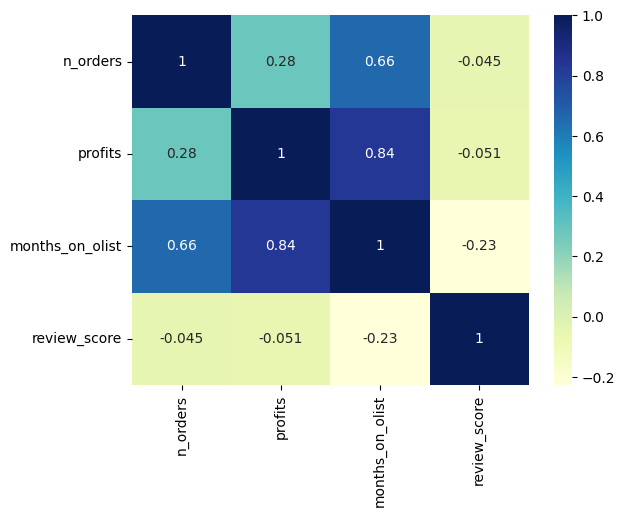

In [35]:
# calculate the correlation matrix on the numeric columns of the reduced dataset(low profitable sellers removed)
corr = sellers_df.corr()

# plot the heatmap
sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()


There is a strong co-relation between 'months_on_olist' and 'profits' </br>

### TO DO : Geopandas implementation 

In [36]:
!pip install geobr


In [79]:
import geopandas as gpd
import geobr

# Use Geopandas to Draw a map of Brazil, plot the location of the sellers with the highest profits in green and the lowest in red.

states = geobr.read_state(year=2019)

print("States in Brazil per geobr: ", len(states['abbrev_state'].unique()))
print(sorted(states['abbrev_state'].unique()) , "\n ==============================")
print("States in Brazil in our dataframe: ", len(sellers_df['seller_state'].unique()))
print(sorted(sellers_df['seller_state'].unique()))


States in Brazil per geobr:  27
['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'SP', 'TO'] 
States in Brazil in our dataframe:  20
['BA', 'CE', 'DF', 'ES', 'GO', 'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RS', 'SC', 'SE', 'SP']


(-76.24758052684999, -26.59070825415, -35.70232894755001, 7.222992030549992)

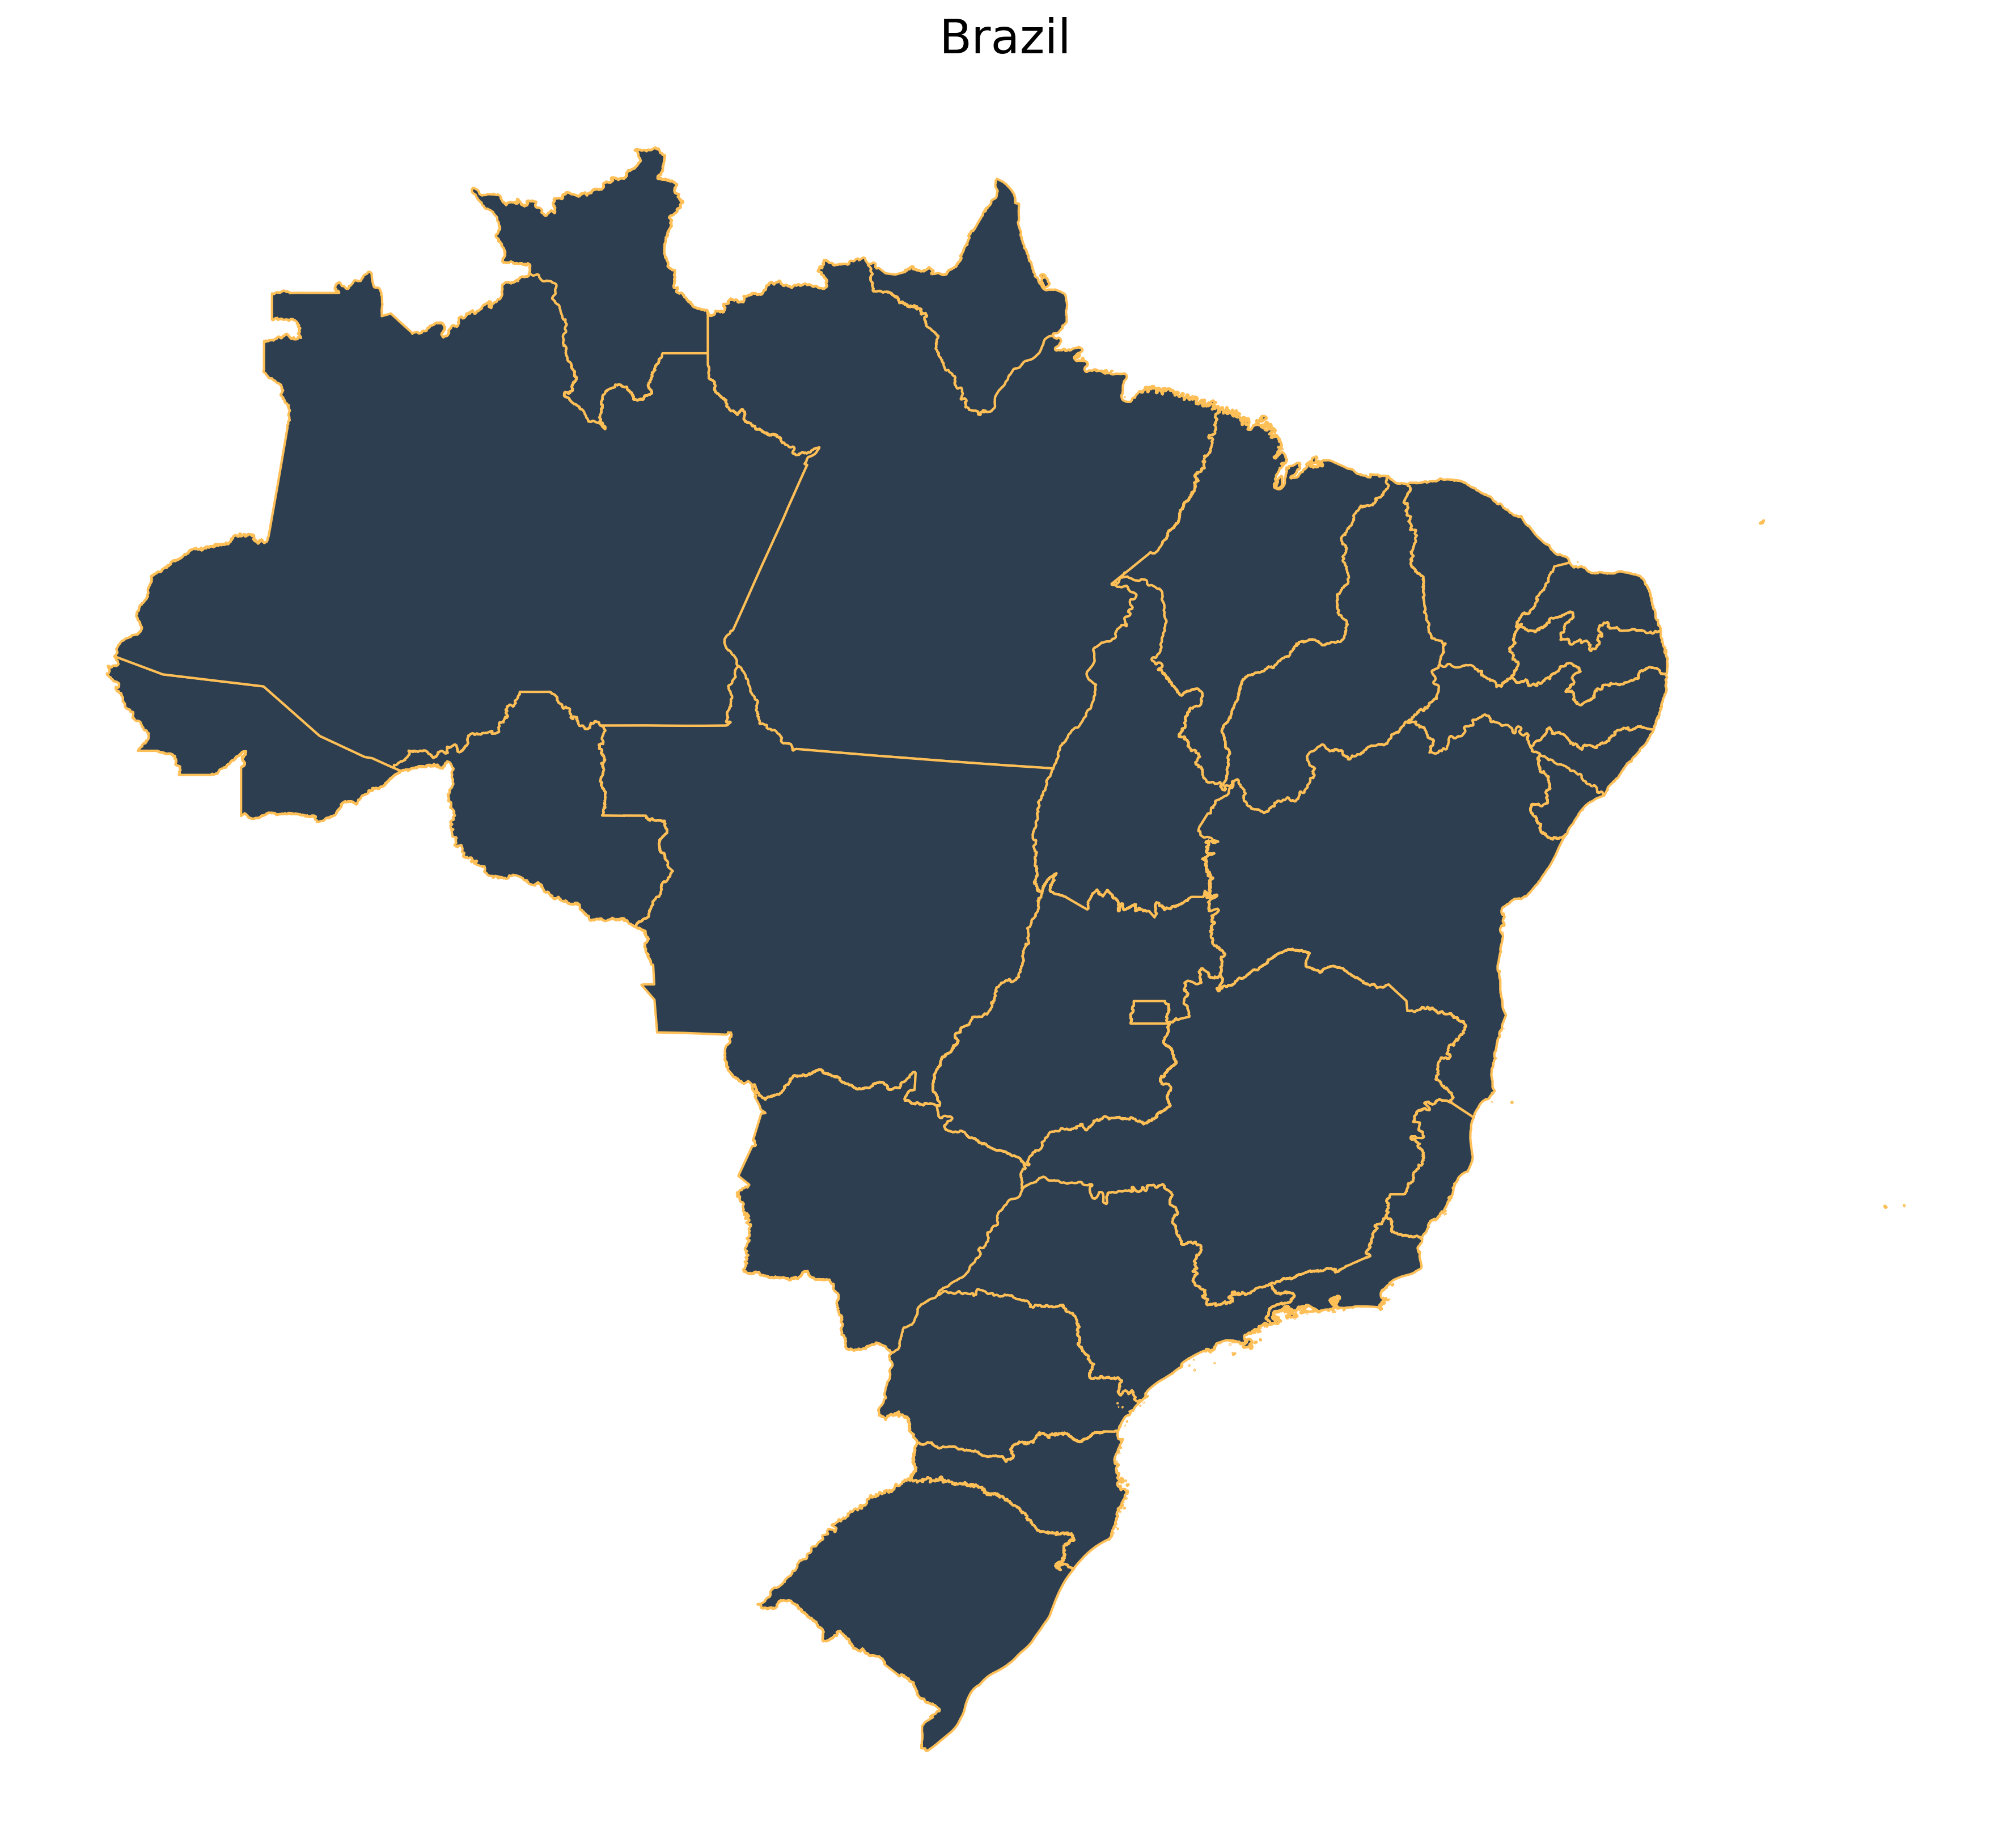

In [90]:
fig, ax = plt.subplots(figsize=(15, 15), dpi=300)

states.plot(facecolor="#2D3E50", edgecolor="#FEBF57", ax=ax)

ax.set_title("Brazil", fontsize=20)
ax.axis("off")


In [91]:
states_profits = sellers_df.groupby(['seller_state', 'seller_city']).agg({'profits': 'sum'}).sort_values(by='profits', ascending=False).reset_index()
#states_profits


# join the databases
states = states.merge(states_profits, left_on='abbrev_state', right_on='seller_state')
states.head(5)


,code_state,abbrev_state,name_state,code_region,name_region,geometry,seller_state,seller_city,profits
0,11.0,RO,Rondônia,1.0,Norte,"MULTIPOLYGON (((-65.38150 -10.42907, -65.37916...",RO,ji parana,417.4339
1,11.0,RO,Rondônia,1.0,Norte,"MULTIPOLYGON (((-65.38150 -10.42907, -65.37916...",RO,porto velho,203.0603
2,15.0,PA,Pará,1.0,Norte,"MULTIPOLYGON (((-51.43248 -0.47334, -51.42843 ...",PA,marechal candido rondon,330.8289
3,22.0,PI,Piauí,2.0,Nordeste,"MULTIPOLYGON (((-42.91539 -6.64607, -42.91722 ...",PI,teresina,460.7868
4,23.0,CE,Ceará,2.0,Nordeste,"MULTIPOLYGON (((-41.18292 -4.01797, -41.18862 ...",CE,fortaleza,2410.5467


(-68.708373827, -26.949718096999998, -35.56828824600001, 4.408137298000002)

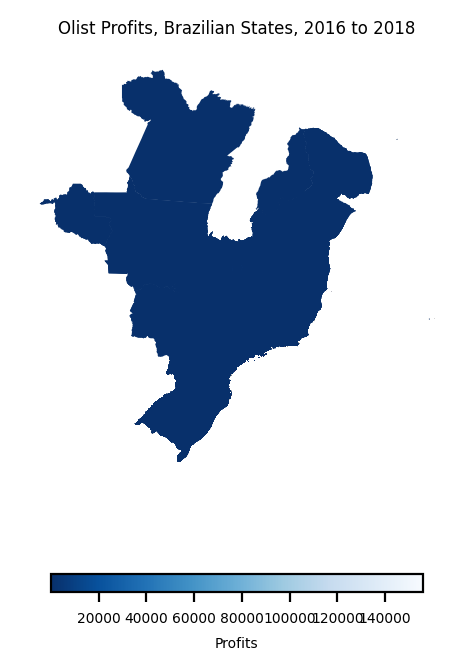

In [92]:
plt.rcParams.update({"font.size": 5})

fig, ax = plt.subplots(figsize=(15, 15), dpi=200)

states.plot(
    column="profits",
    cmap="Blues_r",
    legend=True,
    legend_kwds={
        "label": "Profits",
        "orientation": "horizontal",
        "shrink": 0.6,
    },
    ax=ax,
)

ax.set_title("Olist Profits, Brazilian States, 2016 to 2018")
ax.axis("off")


In [65]:
#Plot thematic map of Brazil with the location of the sellers with the highest profits in green and the lowest in red.
states_profits.plot(column='profits', cmap='RdYlGn', legend=True, ax=ax)

ax.set_title("Brazil", fontsize=20)
ax.axis("off")


(-78.63997246744998, 23.64952249845, -20571.2737568937, 431254.22297889966)